# 7.3 状態空間モデル(state space model)

In [1]:
# パッケージの読み込み
using Distributions, PyPlot, ForwardDiff, LinearAlgebra

In [2]:
# n次元単位行列
eye(n) = Diagonal{Float64}(I, n)

# パラメータ抽出用の関数
unzip(a) = map(x -> getfield.(a, x), fieldnames(eltype(a)))

unzip (generic function with 1 method)

In [3]:
function set_options(ax, xlabel, ylabel, title;
                     grid=true, gridy=false, legend=false)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if grid
        if gridy
            ax.grid(axis="y")
        else
            ax.grid()
        end
    end
    legend && ax.legend()
    return
end

set_options (generic function with 1 method)

In [4]:
# ハミルトニアンモンテカルロ法
function HMC(log_p_tilde, μ₀; maxiter::Int=100_000, L::Int=100, ϵ::Float64=1e-1)
    # leapfrogによる値の更新
    function leapflog(grad, p_in, μ_in, L, ϵ)
        μ = μ_in
        p = p_in + 0.5 * ϵ * grad(μ)
        for l in 1:L-1
            μ += ϵ * p
            p += ϵ * grad(μ)
        end
        μ += ϵ * p
        p += 0.5 * ϵ * grad(μ)
        p, μ
    end
    
    # 非正規化対数事後分布の勾配関数を計算
    grad(μ) = ForwardDiff.gradient(log_p_tilde, μ)
    
    # サンプルを格納する配列
    D = length(μ₀)
    μ_samples = Array{typeof(μ₀[1]), 2}(undef, D, maxiter)
    
    # 初期サンプル
    μ_samples[:, 1] = μ₀
    
    # 受容されたサンプルの数
    num_accepted = 1
    
    for i in 2:maxiter
        # 運動量 p の生成
        p_in = randn(size(μ₀))
        
        # リープフロッグ法
        p_out, μ_out = leapflog(grad, p_in, μ_samples[:, i-1], L, ϵ)
                
        # 比率 r (の対数)を計算
        μ_in = μ_samples[:, i-1]
        log_r = (log_p_tilde(μ_out) +
                 logpdf(MvNormal(zeros(D), eye(D)), vec(p_out))) -
                (log_p_tilde(μ_in) +
                 logpdf(MvNormal(zeros(D), eye(D)), vec(p_in)))
        
        # 確率 r でサンプルを受容する
        is_accepted = min(1, exp(log_r)) > rand()
        new_samples = is_accepted ? μ_out : μ_in
        
        # 新しいサンプルを格納
        μ_samples[:, i] = new_samples
        
        # 受容された場合、合計をプラスする
        num_accepted += is_accepted
    end
    
    μ_samples, num_accepted
end

HMC (generic function with 1 method)

In [5]:
# ラッパー関数の定義
function inference_wrapper_HMC(log_joint, paras, w_init; 
                               maxiter::Int=100000, L::Int=100, ϵ::Float64=1e-1)
    ulp(w) = log_joint(w, paras...)
    HMC(ulp, w_init, maxiter=maxiter, L=L, ϵ=ϵ)
end

inference_wrapper_HMC (generic function with 1 method)

## 7.3.1 スムージング

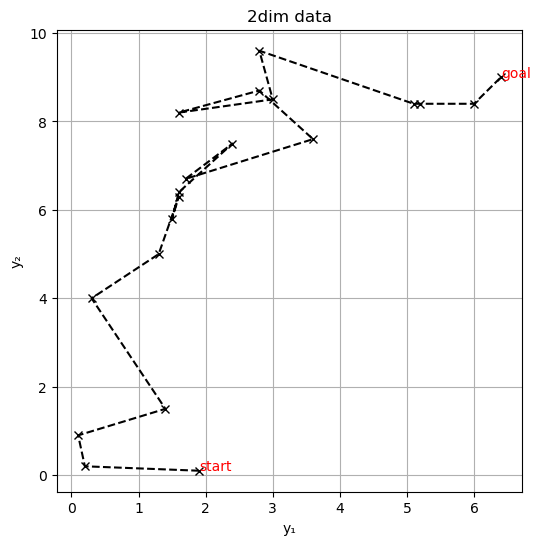

In [6]:
# 系列の長さ
N = 20

# 観測データの次元
D = 2

# 系列データ（#=, =#は複数行をつなげるために挿入)
Y_obs = 
    [1.9 0.2 0.1 1.4 0.3 1.3 1.6 1.5 1.6 2.4 #=
  =# 1.7 3.6 2.8 1.6 3.0 2.8 5.1 5.2 6.0 6.4;
     0.1 0.2 0.9 1.5 4.0 5.0 6.3 5.8 6.4 7.5 #=
  =# 6.7 7.6 8.7 8.2 8.5 9.6 8.4 8.4 8.4 9.0]

# 2次元に系列データを可視化
fig, ax = subplots(figsize=(6,6))
ax.plot(Y_obs[1,:], Y_obs[2,:], "kx--")
ax.text(Y_obs[1,1], Y_obs[2,1], "start", color="r")
ax.text(Y_obs[1,end], Y_obs[2,end], "goal", color="r")
set_options(ax, "y₁", "y₂", "2dim data")

In [7]:
# 初期状態に与えるノイズ量
σ₁ = 100.0

# 状態の遷移に仮定するノイズ量
σ_x = 1.0

# 観測に仮定するノイズ量
σ_y = 1.0

# 状態の遷移系列に関する対数密度
@views transition(X, σ₁, σ_x, D, N) = 
    logpdf(MvNormal(zeros(D), σ₁ * eye(D)), X[:, 1]) +
    sum([logpdf(MvNormal(X[:, n-1], σ_x * eye(D)), X[:, n]) for n in 2:N])

# 観測データに関する対数密度
@views observation(X, Y, σ_y, D, N) = 
    sum([logpdf(MvNormal(X[:, n], σ_y * eye(D)), Y[:, n]) for n in 1:N])

# 対数同時分布
log_joint_tmp(X, Y, σ₁, σ_x, σ_y, D, N) = 
    transition(X, σ₁, σ_x, D, N) + observation(X, Y, σ_y, D, N)

# DN次元ベクトルを入力とする関数にする
log_joint(X_vec, Y, σ₁, σ_x, σ_y, D, N) = log_joint_tmp(reshape(X_vec, D, N), Y, σ₁, σ_x, σ_y, D, N)
paras = (Y_obs, σ₁, σ_x, σ_y, D, N)

# 非正規化対数事後分布
ulp(X_vec) = log_joint(X_vec, paras...)

ulp (generic function with 1 method)

In [8]:
# 初期値
w_init = randn(D*N)

# サンプリング
maxiter = 1000
param_posterior_HMC, num_accepted_HMC =
    inference_wrapper_HMC(log_joint, paras, w_init, maxiter=maxiter)
println("acceptance rate = $(num_accepted_HMC/maxiter)")

acceptance rate = 0.991


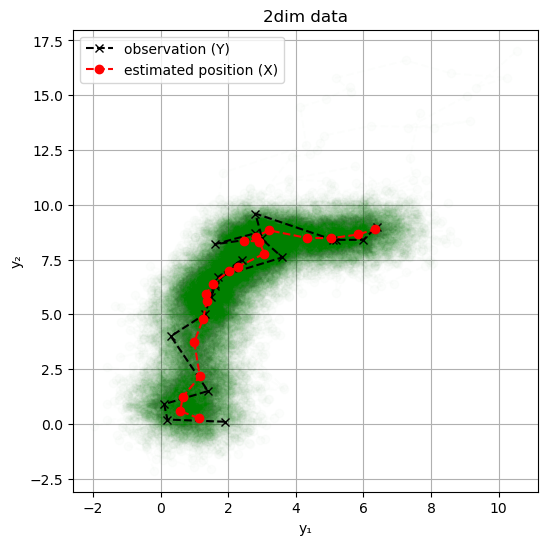

In [9]:
fig, ax = subplots(figsize=(6,6))
for i in 1:maxiter
    # i番目のサンプルの状態変数
    X = reshape(param_posterior_HMC[:, i], 2, N)
    ax.plot(X[1,:], X[2,:], "go--", alpha=10.0/maxiter)
end

# 観測データの可視化
ax.plot(Y_obs[1,:], Y_obs[2,:], "kx--", label="observation (Y)")

# 状態変数の平均
mean_trace = reshape(mean(param_posterior_HMC, dims=2), 2, N)
ax.plot(mean_trace[1,:], mean_trace[2, :], "ro--", label="estimated position (X)")
set_options(ax, "y₁", "y₂", "2dim data", legend=true)

## 7.3.2 回帰への適用

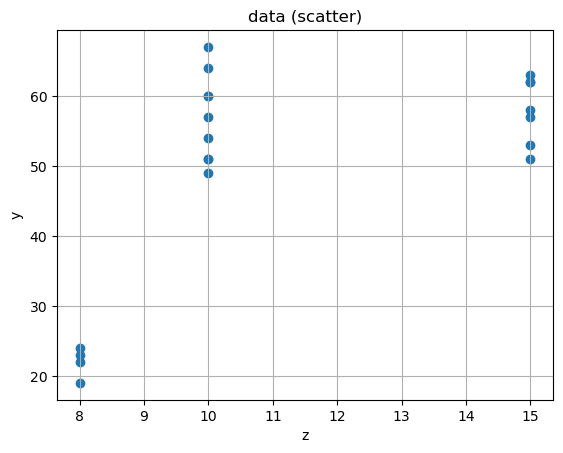

In [10]:
# 観測データ数
N = 20

# 入力値
Z_obs = [10, 10, 10, 10, 10, 10, 10, 10, 10, 15,
         15, 15, 15, 15, 15, 15,  8,  8,  8,  8]
Y_obs = [67, 64, 60, 60, 57, 54, 51, 51, 49, 63,
         62, 62, 58, 57, 53, 51, 24, 22, 23, 19]

# データの可視化
fig, ax = subplots()
ax.scatter(Z_obs, Y_obs)
set_options(ax, "z", "y", "data (scatter)")

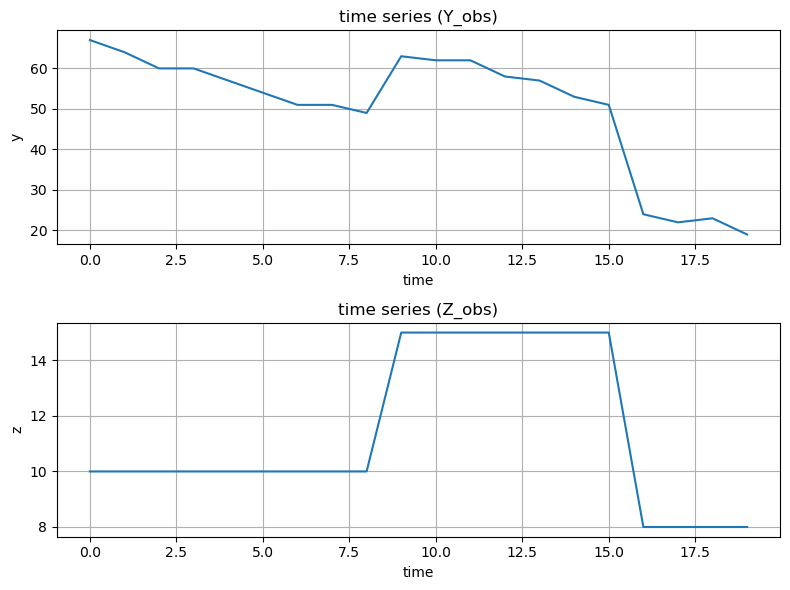

In [11]:
fig, axes = subplots(2, 1, figsize=(8, 6))

# 出力値
axes[1].plot(Y_obs)
set_options(axes[1], "time", "y", "time series (Y_obs)")

# 入力値
axes[2].plot(Z_obs)
set_options(axes[2], "time", "z", "time series (Z_obs)")

tight_layout()

In [12]:
# 初期状態に与えるノイズ量
σ₁ = 10.0

# 状態の遷移に仮定するノイズ量
σ_x = 1.0

# 観測に仮定するノイズ量
σ_y = 0.5

# パラメータに仮定するノイズ量
σ_w = 100.0

# パラメータの事前分布
prior(w, σ_w) = logpdf(MvNormal(zeros(2), σ_w * eye(2)), w)

# 状態の遷移系列に関する対数密度
@views transition(X, σ₁, σ_x) = 
    logpdf(Normal(0, σ₁), X[1]) +
    sum(logpdf.(Normal.(X[1:N-1], σ_x), X[2:N]))

# 観測データに関する対数密度
@views observation(X, Y, Z, w) = 
    sum(logpdf.(Normal.(w[1] * Z .+ w[2] + X, σ_y), Y))

# 対数同時分布
log_joint_tmp(X, w, Y, Z, σ_w, σ₁, σ_x) = 
    transition(X, σ₁, σ_x) + observation(X, Y, Z, w) + prior(w, σ_w)
# log_joint_tmp(X, w, Y, Z, σ_w, σ₁, σ_x) = 
#     observation(X, Y, Z, w) + prior(w, σ_w)
@views log_joint(X_vec, Y, Z, σ_w, σ₁, σ_x) = 
    log_joint_tmp(X_vec[1:N], X_vec[N+1:N+2], Y, Z, σ_w, σ₁, σ_x)
paras = (Y_obs, Z_obs, σ_w, σ₁, σ_x)

# 非正規化対数事後分布
# ulp(X_vec) = log_joint(X_vec, w, paras...)

([67, 64, 60, 60, 57, 54, 51, 51, 49, 63, 62, 62, 58, 57, 53, 51, 24, 22, 23, 19], [10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 15, 15, 15, 15, 15, 15, 8, 8, 8, 8], 100.0, 10.0, 1.0)

In [13]:
# 初期値
x_init = randn(N+2)

# サンプリング
maxiter = 1000
param_posterior_HMC, num_accepted_HMC =
    inference_wrapper_HMC(log_joint, paras, x_init, maxiter=maxiter, L=100, ϵ=1e-2)
println("acceptance rate = $(num_accepted_HMC/maxiter)")

acceptance rate = 0.959


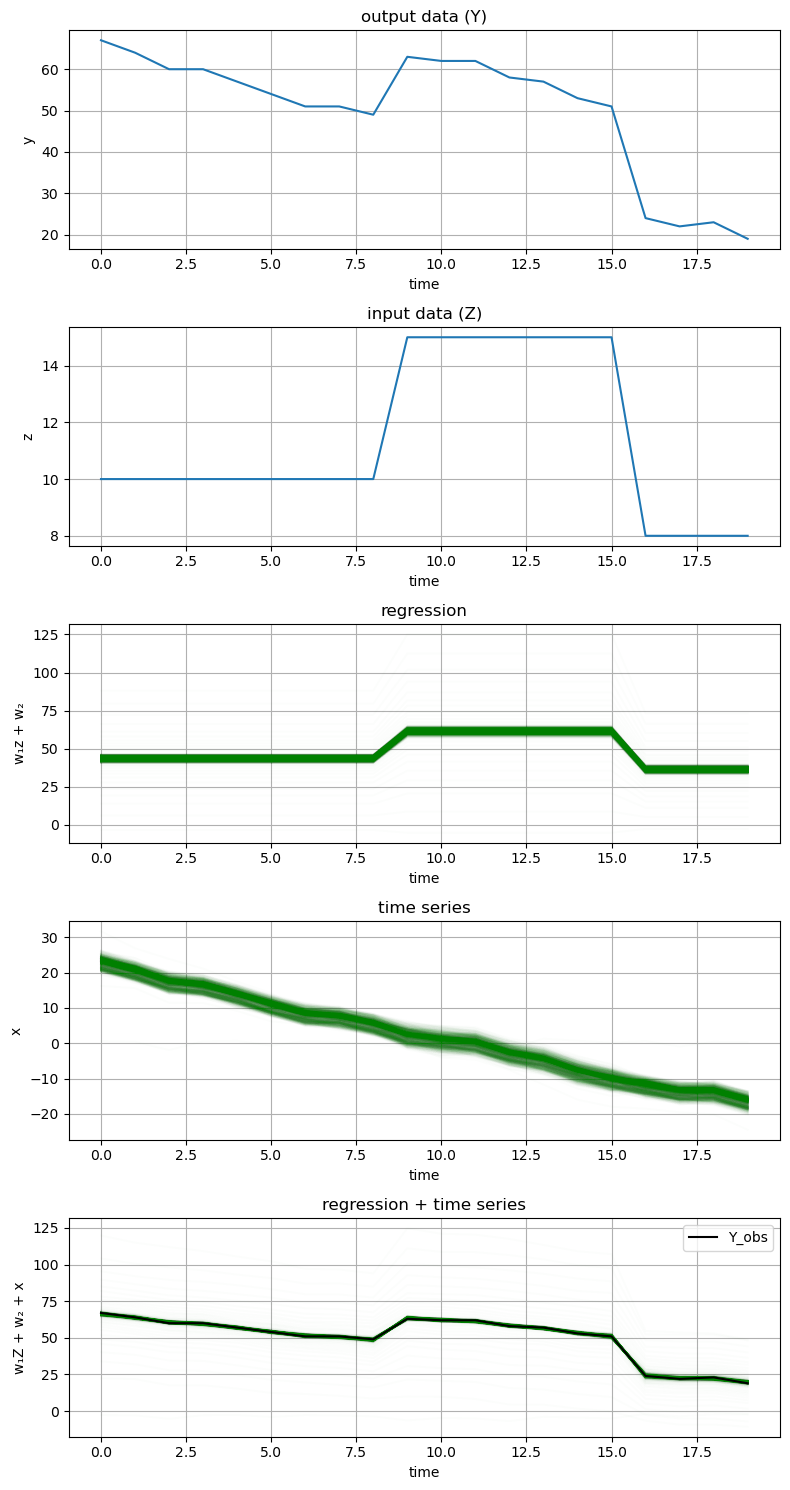

In [14]:
# 推定結果の可視化
fig, axes = subplots(5, 1, figsize=(8,15))

# 出力値
axes[1].plot(Y_obs)
set_options(axes[1], "time", "y", "output data (Y)")

# 入力値
axes[2].plot(Z_obs)
set_options(axes[2], "time", "z", "input data (Z)")

# 回帰によって説明される成分
for i in 1:maxiter
    w₁, w₂ = param_posterior_HMC[[N+1, N+2], i]
    axes[3].plot(w₁ * Z_obs .+ w₂, "g-", alpha=10/maxiter)
end
set_options(axes[3], "time", "w₁z + w₂", "regression")

# 状態変数によって説明される成分
for i in 1:maxiter
    X = param_posterior_HMC[1:N, i]
    axes[4].plot(X, "g-", alpha=10/maxiter)
end
set_options(axes[4], "time", "x", "time series")

# 回帰と状態変数の和
for i in 1:maxiter
    w₁, w₂ = param_posterior_HMC[[N+1, N+2], i]
    X = param_posterior_HMC[1:N, i]
    axes[5].plot(w₁ * Z_obs .+ w₂ + X, "g-", alpha=10/maxiter)
end
axes[5].plot(Y_obs, "k", label="Y_obs")
set_options(axes[5], "time", "w₁Z + w₂ + x", "regression + time series", legend=true)

tight_layout()